In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load CSV file
filepath = Path.cwd().parent/"dataSet" / "player_stats.csv"
data = pd.read_csv(filepath, encoding='latin1')
df = data.drop_duplicates()


In [3]:
# Remove dots and dollar signs, and convert to float
df['value'] = df['value'].replace('[^\d]', '', regex=True).astype(float)

/var/folders/2j/l0l766lj1211qpwvb1rrv7sh0000gp/T/ipykernel_71860/1828184651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].replace('[^\d]', '', regex=True).astype(float)


In [4]:
# Remove null column and player column as the name should not affect the market value  
df.drop('marking', axis=1, inplace=True)
df.drop('player', axis=1, inplace=True)

/var/folders/2j/l0l766lj1211qpwvb1rrv7sh0000gp/T/ipykernel_71860/1648356707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('marking', axis=1, inplace=True)
/var/folders/2j/l0l766lj1211qpwvb1rrv7sh0000gp/T/ipykernel_71860/1648356707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('player', axis=1, inplace=True)


In [5]:
# Encode categorical columns to integers if present
categorical_columns = ['country', 'club']  # Removed 'player' as it was dropped earlier
for col in categorical_columns:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])

/var/folders/2j/l0l766lj1211qpwvb1rrv7sh0000gp/T/ipykernel_71860/2881489692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = LabelEncoder().fit_transform(df[col])
/var/folders/2j/l0l766lj1211qpwvb1rrv7sh0000gp/T/ipykernel_71860/2881489692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = LabelEncoder().fit_transform(df[col])


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

GK_df = df[["gk_handling", "gk_kicking","gk_reflexes","gk_positioning","gk_diving"]]
#scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(GK_df)

# Apply PCA
pca = PCA(n_components=1)
principal_components = pca.fit_transform(scaled_data)

# Variance explained by the principal component
print(f"Explained Variance: {pca.explained_variance_ratio_}")

# Create DataFrame for principal components
principal_df = pd.DataFrame(data=principal_components, columns=['gk_Principal_Component'])

# Join the principal components DataFrame with the encoded dataset
df.drop(["gk_handling", "gk_kicking","gk_reflexes","gk_positioning","gk_diving"], axis=1, inplace=True)
df = df.merge(principal_df, left_index=True, right_index=True)

Explained Variance: [0.97665296]


/var/folders/2j/l0l766lj1211qpwvb1rrv7sh0000gp/T/ipykernel_71860/2873288229.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["gk_handling", "gk_kicking","gk_reflexes","gk_positioning","gk_diving"], axis=1, inplace=True)


In [7]:
# Separate features and target
X = df.drop('value', axis=1)  
y = df['value']

In [8]:
# Split the dataset into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.7, random_state=25)

# Further split the test set into training and validation sets (70% testing, 30% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,train_size = 0.7, random_state=25)

In [9]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 7680617171183.443
R-squared Score: 0.826115161310985


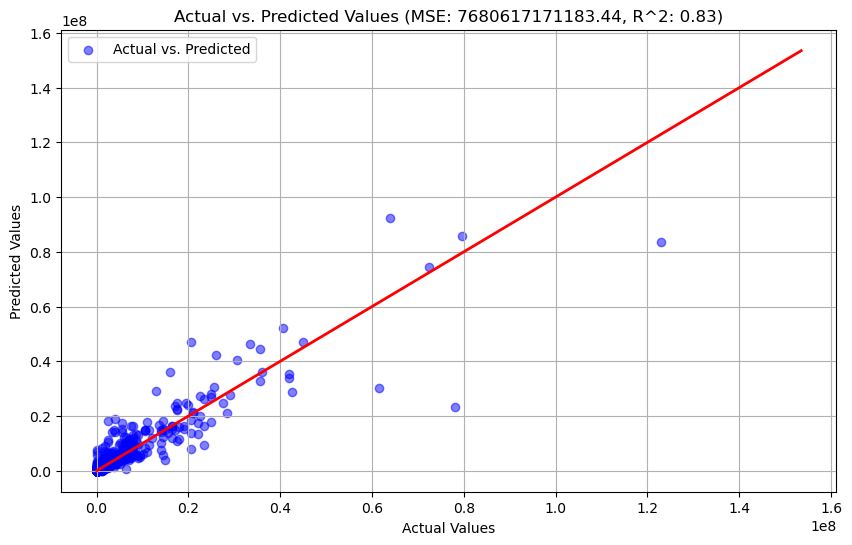

In [10]:
# Create scatter plot for actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, c='blue', label='Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs. Predicted Values (MSE: {mse:.2f}, R^2: {r2:.2f})')

# create diagonal line that shows perfect prediction
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=2)
plt.legend()
plt.grid(True)
plt.show()



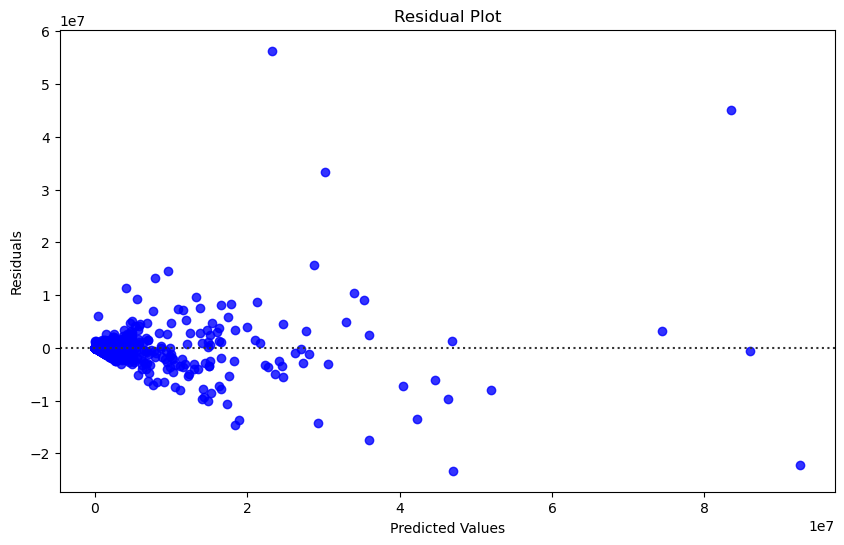

In [11]:
## Residual Plot
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=y_test - predictions, color="b")
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

Training Sizes: [ 454 1362 2270 3178 4086 4540] 
 Training Scores: [[-1.11970728e+12 -1.48619259e+12 -1.48619259e+12 -1.48619259e+12
  -1.48619259e+12]
 [-1.52045727e+12 -1.74276252e+12 -1.47640729e+12 -1.47640729e+12
  -1.47640729e+12]
 [-1.56287068e+12 -1.23096005e+12 -1.28346587e+12 -1.28346587e+12
  -1.28346587e+12]
 [-1.09636404e+12 -9.96364824e+11 -1.08245168e+12 -1.21709449e+12
  -1.21709449e+12]
 [-1.13859274e+12 -9.46699172e+11 -9.85875956e+11 -1.05245841e+12
  -1.01276998e+12]
 [-9.92643363e+11 -1.00985176e+12 -9.68133472e+11 -9.81056325e+11
  -9.46349352e+11]] 
 test_scores : [[-1.20155468e+13 -1.28828603e+13 -1.27980309e+13 -1.73485045e+13
  -4.78367720e+13]
 [-9.54986415e+12 -9.37753920e+12 -8.97094778e+12 -9.91311193e+12
  -2.10467296e+13]
 [-8.00255700e+12 -7.71958724e+12 -8.88002603e+12 -8.88014684e+12
  -1.57273011e+13]
 [-6.96107900e+12 -5.69305885e+12 -6.29689756e+12 -6.90238760e+12
  -1.68057176e+13]
 [-5.70506220e+12 -6.45111736e+12 -6.05905404e+12 -7.35885565e+12


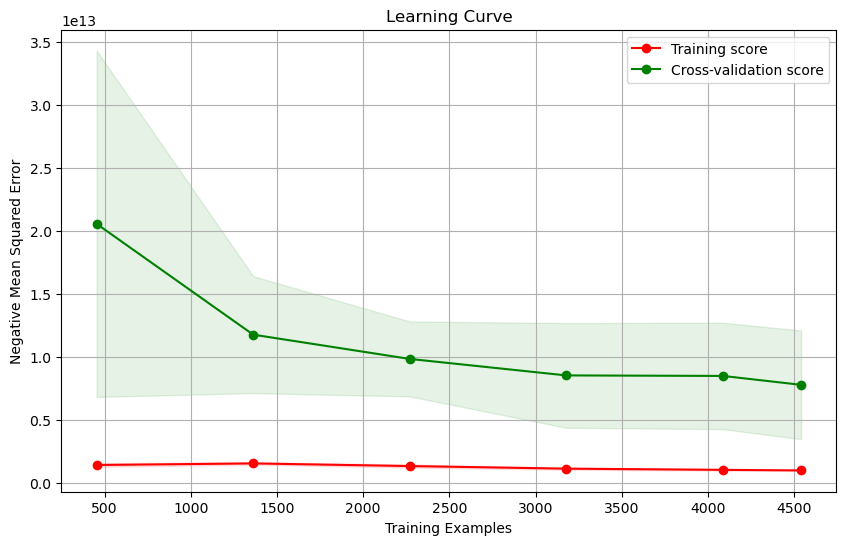

In [12]:
#visualise this models learning curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(random_state=42), X, y, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], 
    cv=5, scoring='neg_mean_squared_error', random_state=42
)

print(f"Training Sizes: {train_sizes} \n Training Scores: {train_scores} \n test_scores : {test_scores}")

# Calculate mean and standard deviation for training set scores and validation set scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Parameters: max_depth = None, min_samples_split = 2, min_samples_leaf = 1
Mean Squared Error: 7891533925927.652

R-squared score: 0.8213401250009984

Parameters: max_depth = None, min_samples_split = 2, min_samples_leaf = 2
Mean Squared Error: 8010028947537.0205

R-squared score: 0.8186574645768725

Parameters: max_depth = None, min_samples_split = 15, min_samples_leaf = 1
Mean Squared Error: 8806624969014.342

R-squared score: 0.800622980158799

Parameters: max_depth = None, min_samples_split = 15, min_samples_leaf = 2
Mean Squared Error: 8715696267047.34

R-squared score: 0.8026815546615167

Parameters: max_depth = 10, min_samples_split = 2, min_samples_leaf = 1
Mean Squared Error: 8106683327087.778

R-squared score: 0.8164692639645796

Parameters: max_depth = 10, min_samples_split = 2, min_samples_leaf = 2
Mean Squared Error: 8063643635265.048

R-squared score: 0.8174436583007404

Parameters: max_depth = 10, min_samples_split = 15, min_samples_leaf = 1
Mean Squared Error: 8857139230

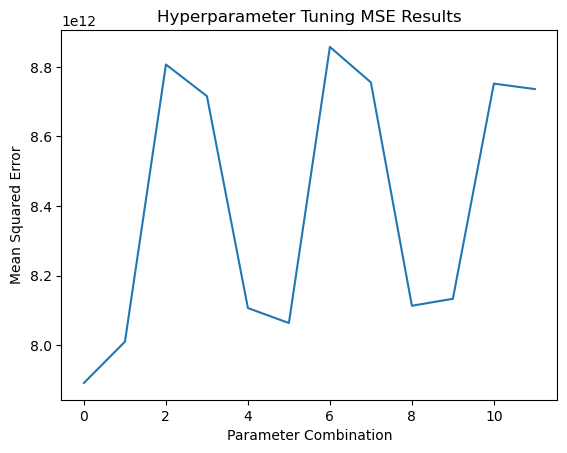

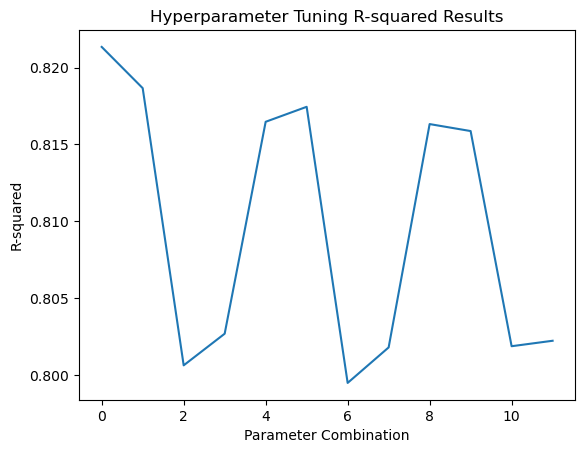

In [16]:
#Basic hyperparameter tuning
max_depths = [None, 10, 30]
min_samples_splits = [2, 15]
min_samples_leafs = [1, 2]

# Lists to store performance metrics
MSE = []
R2 = []

# Hyperparameter tuning loop
for depth in max_depths:
    for min_samples_split in min_samples_splits:
        for min_samples_leaf in min_samples_leafs:
            
            # Initialize and train DecisionTreeRegressor
            model = RandomForestRegressor(max_depth=depth, 
                                             min_samples_split=min_samples_split,
                                             min_samples_leaf=min_samples_leaf,
                                             random_state=25)
            
            model.fit(X_train, y_train)
            
            # Make predictions and compute Mean Squared Error and R-squared score
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Append MSE and R2 to the list
            MSE.append(mse)
            R2.append(r2)
            
            # Print the results
            print(f"Parameters: max_depth = {depth}, min_samples_split = {min_samples_split}, min_samples_leaf = {min_samples_leaf}")
            print(f"Mean Squared Error: {mse}\n")
            print(f"R-squared score: {r2}\n")

# Plotting results
# Visualize the MSE values corresponding to different hyperparameters
plt.plot(range(len(MSE)), MSE)
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Squared Error')
plt.title('Hyperparameter Tuning MSE Results')
plt.show()

# Visualize the R-Squared score values corresponding to different hyperparameters
plt.plot(range(len(R2)), R2)
plt.xlabel('Parameter Combination')
plt.ylabel('R-squared')
plt.title('Hyperparameter Tuning R-squared Results')
plt.show()

R^2 Score: 0.8996248071794241
Mean Squared Error: 7214695831694.318


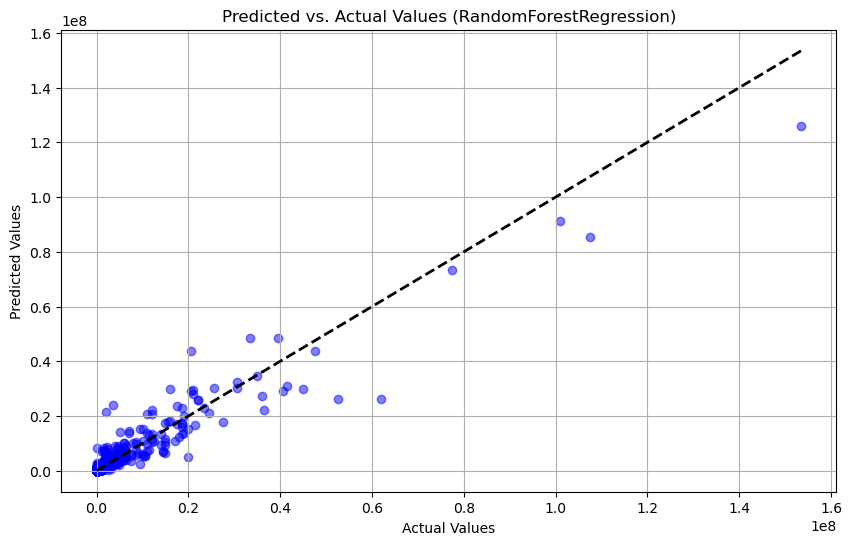

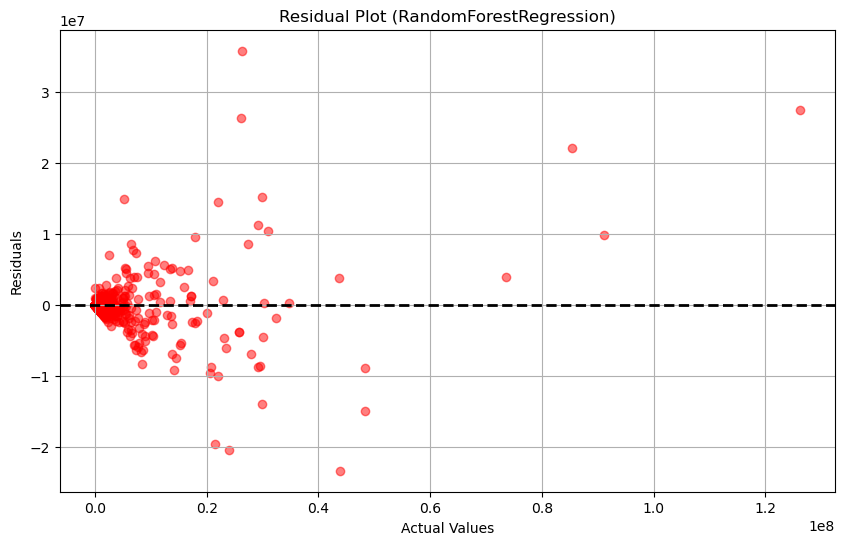

In [14]:
# Predictions
best_model = RandomForestRegressor(max_depth=30, 
                                             min_samples_split=2,
                                             min_samples_leaf=1,
                                             random_state=25)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_valid)

# Evaluate with different metrics
r2score = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
print(f"R^2 Score: {r2score}")
print(f"Mean Squared Error: {mse}")


# Plotting the Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, color='blue', alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (RandomForestRegression)')
plt.grid(True) 
plt.show()

# Calculate residuals
residuals = y_valid - y_pred

# Plotting the Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='red', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (RandomForestRegression)')
plt.grid(True)
plt.show()

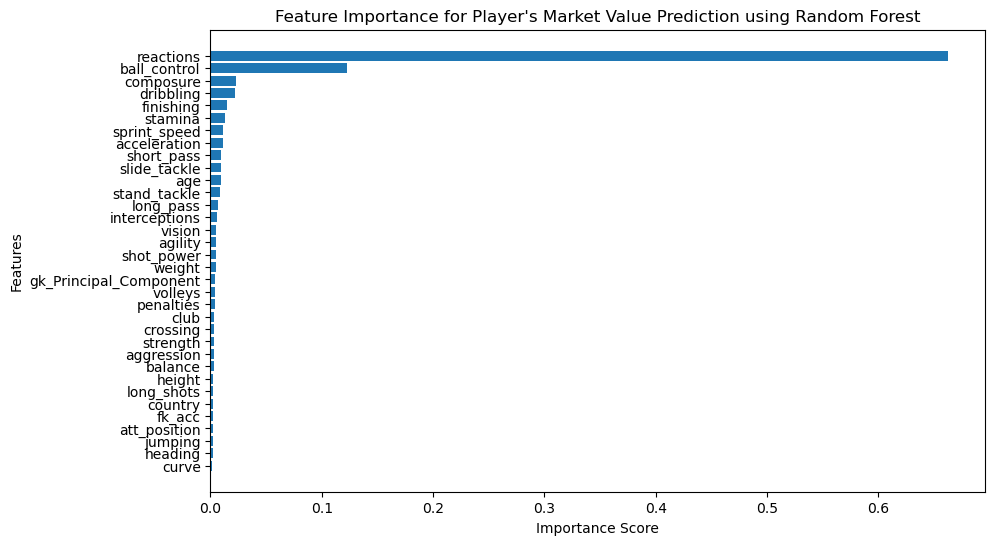

In [15]:
# Get feature importance
feature_importance = best_model.feature_importances_

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance for Player\'s Market Value Prediction using Random Forest')
# Invert y-axis for better visualization
plt.gca().invert_yaxis()  
plt.show()